In [5]:
# Required for DADVI experiments, running TAVIE and other BBVI algorithms
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import arviz as az
import re

# Student

In [6]:
def student_t_pymc_model(X, y, nu, a0=0.05, b0=0.05):
    """
    Student's-t regression with known nu:
        y ~ StudentT(nu, mu = X @ beta, sigma = 1/sqrt(tau2))

    Priors:
        beta ~ Normal(0, 1)      (vector length p)
        tau2 ~ Gamma(a0/2, b0/2) [shape-rate]
    """
    # ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n, p = X.shape
    dtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # data
        X_data = pm.MutableData("X", X.astype(dtype))
        y_data = pm.MutableData("y", y.astype(dtype))

        # priors
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)
        tau2 = pm.Gamma("tau2", alpha=a0/2, beta=b0/2)   # precision

        # mean
        mu = pt.dot(X_data, beta)

        # Student-t likelihood with known nu
        pm.StudentT("y_obs", nu=nu, mu=mu, sigma=1 / pt.sqrt(tau2), observed=y_data)

    return model


def fit_NUTS_student_t(model):
    """
    Fit the Student's-t model with NUTS and return posterior means for beta and tau2.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    # Fitting the NUTS model
    with model as model:
        nuts_model = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(nuts_model, var_names=["beta", "tau2"])[["mean"]]

    # tau2 mean (scalar)
    tau2_mean = float(summ.loc[summ.index == "tau2", "mean"].values[0])

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    post_means = {"beta": np.array(beta_mean), "tau2": tau2_mean}
    return post_means

## For (n, p) = (1000, 8): ELBO plot ADVI (MF/FR) and TAVIE-SSG

In [8]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
df = 5
num_reps = 100
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Initialize TAVIE once
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# ---- TAVIE ----
student_tavie_model.fit(X, y, nu=df, verbose=False)

# ADVI mean-field estimator
res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)

# ADVI full-rank estimator
res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                    tol=1e-9, verbose=False)

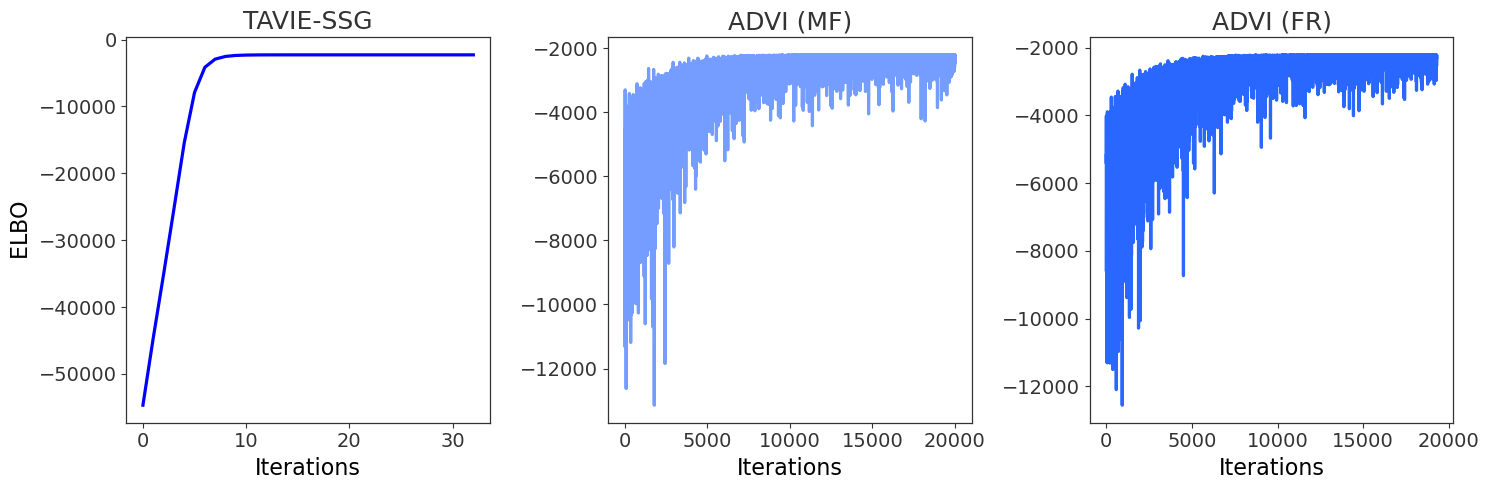

In [23]:
tavie_elbo = student_tavie_model.get_elbo()
advi_mf_elbo = res2['elbo_hist']
advi_fr_elbo = res3['elbo_hist']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
colors = [
    'blue',  # bright aqua
    '#759DFF',  # turquoise blue
    '#2967FF'   # strong deep blue
]
axes[0].plot(tavie_elbo, color=colors[0], linewidth=2.3)
axes[0].set_title(r'TAVIE-SSG', fontsize=18, color='#333333')
axes[0].set_xlabel('Iterations', fontsize=16)
axes[0].set_ylabel(r'$\mathsf{ELBO}$', fontsize=16)

axes[1].plot(advi_mf_elbo, color=colors[1], linewidth=2.3)
axes[1].set_title(r'ADVI (MF)', fontsize=18, color='#333333')
axes[1].set_xlabel('Iterations', fontsize=16)

axes[2].plot(advi_fr_elbo, color=colors[2], linewidth=2.3)
axes[2].set_title(r'ADVI (FR)', fontsize=18, color='#333333')
axes[2].set_xlabel('Iterations', fontsize=16)

# --- Shared styling ---
for ax in axes:
    #ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(0.9)
    ax.tick_params(axis='both', labelsize=14, colors='#333333')

plt.tight_layout()
#fig.suptitle(r'$\mathsf{ELBO}$ Convergence Trajectories', fontsize=17, color='#333333', y=1.03)

# Save high-resolution figure
fig.savefig(f'results_compete/plots/Student_ELBO_n_{n}_p_{p}.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## For multiple sample sizes n and fixed features p = 8

In [7]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
df = 5
num_reps = 100
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
mse_tau2_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_MFVI          = np.zeros((n_sizes, num_reps))
mse_tau2_MFVI          = np.zeros((n_sizes, num_reps))
time_MFVI              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
mse_tau2_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
mse_tau2_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# Initialize TAVIE once
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
        y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

        # ---- TAVIE ----
        t0 = perf_counter()
        student_tavie_model.fit(X, y, nu=df, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # MFVI estimator
        t0 = perf_counter()
        beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                      mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                      A=2, B=2, nu_min=2.0, 
                                                      nu_max=20.0, tol=1e-6, verbose = False)
        time_MFVI[i, rep] = perf_counter() - t0
        beta_est2 = beta_hat
        tau2_est2 = 1/sigma_sq_hat
        mse_beta_MFVI[i, rep] = np.mean((beta_est2 - beta_true)**2)
        mse_tau2_MFVI[i, rep] = (tau2_est2 - tau2_true)**2

        # DADVI estimator
        student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)
        t0 = perf_counter()
        student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = student_dadvi_res['beta']
        tau2_est_DADVI = np.exp(student_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        student_nuts_res = fit_NUTS_student_t(student_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = student_nuts_res['beta']
        tau2_est_NUTS = student_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        tau2_est_ADVI_mf = res2['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_est_ADVI_mf - tau2_true)**2

        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                          tol=1e-9, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        tau2_est_ADVI_fr = res3['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_est_ADVI_fr - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_MFVI':     mse_beta_MFVI,
    'mse_tau2_MFVI':     mse_tau2_MFVI,
    'time_MFVI':         time_MFVI,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Student_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=200:   3%|▎         | 3/100 [01:59<1:05:08, 40.30s/it]

n=200:  15%|█▌        | 15/100 [09:57<55:31, 39.19s/it]  

n=200:  57%|█████▋    | 57/100 [37:36<27:40, 38.62s/it]

n=200:  71%|███████   | 71/100 [46:44<19:28, 40.28s/it]

n=200:  80%|████████  | 80/100 [52:41<12:54, 38.70s/it]

n=200:  96%|█████████▌| 96/100 [1:02:46<02:33, 38.41s/it]

n=500:  31%|███       | 31/100 [22:04<48:50, 42.48s/it]  

n=500:  36%|███▌      | 36/100 [25:36<45:29, 42.64s/it]

n=500:  75%|███████▌  | 75/100 [54:18<17:20, 41.63s/it]

n=500:  91%|█████████ | 91/100 [1:05:54<06:46, 45.17s/it]

n=2000: 100%|██████████| 100/100 [1:19:25<00:00, 47.65s/it]


## For multiple number of features p and fixed sample size n=1000

In [24]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 8, 15, 20]
tau2_true  = 3.0
df = 5
num_reps   = 100

# Hyperparameters for BBVI full‐covariances
a, b = 0.025, 0.025

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
mse_tau2_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_MFVI         = np.zeros((P, num_reps))
mse_tau2_MFVI        = np.zeros((P, num_reps))
time_MFVI            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
mse_tau2_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
mse_tau2_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
mse_tau2_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
mse_tau2_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
        y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

        # ---- TAVIE ----
        t0 = perf_counter()
        student_tavie_model.fit(X, y, nu=df, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # MFVI estimator
        t0 = perf_counter()
        beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                      mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                      A=2, B=2, nu_min=2.0, 
                                                      nu_max=20.0, tol=1e-6, verbose = False)
        time_MFVI[i, rep] = perf_counter() - t0
        beta_est2 = beta_hat
        tau2_est2 = 1/sigma_sq_hat
        mse_beta_MFVI[i, rep] = np.mean((beta_est2 - beta_true)**2)
        mse_tau2_MFVI[i, rep] = (tau2_est2 - tau2_true)**2

        # DADVI estimator
        student_dadvi_model = student_t_pymc_model(X_bbvi, y, nu=df)
        t0 = perf_counter()
        student_dadvi_res = fit_pymc_dadvi_with_jax(student_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = student_dadvi_res['beta']
        tau2_est_DADVI = np.exp(student_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        student_nuts_res = fit_NUTS_student_t(student_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = student_nuts_res['beta']
        tau2_est_NUTS = student_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        tau2_est_ADVI_mf = res2['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_est_ADVI_mf - tau2_true)**2

        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
                                                          tol=1e-9, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        tau2_est_ADVI_fr = res3['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_est_ADVI_fr - tau2_true)**2

        

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_MFVI':     mse_beta_MFVI,
    'mse_tau2_MFVI':     mse_tau2_MFVI,
    'time_MFVI':         time_MFVI,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Student_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=15:  21%|██        | 21/100 [16:43<1:03:14, 48.03s/it]

p=20:  85%|████████▌ | 85/100 [1:09:01<12:07, 48.52s/it]

p=20: 100%|██████████| 100/100 [1:21:14<00:00, 48.75s/it]


# Laplace

In [27]:
def laplace_pymc_model(X, y, a0=0.05, b0=0.05):
    """
    Build and return a PyMC Laplace regression model:
        y ~ Laplace(mu = X @ beta, b)

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
    y : array-like, shape (n,)

    Returns
    -------
    model : pm.Model
    """
    # Ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n, p = X.shape
    dtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # Data containers (so you can update later if you want)
        X_data = pm.MutableData("X", X.astype(dtype))
        y_data = pm.MutableData("y", y.astype(dtype))

        # Priors
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)
        tau2 = pm.Gamma("tau2", alpha=a0/2, beta=b0/2)

        # Linear predictor
        mu = pt.dot(X_data, beta)

        # Laplace likelihood
        pm.Laplace("y_obs", mu=mu, b=1/np.sqrt(tau2), observed=y_data)

    return model

def fit_NUTS_laplace(model):
    
    import logging, warnings
    # Mute PyMC/pytensor logs + warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    # fitting the NUTS model
    with model as model:
        nuts_model = pm.sample(progressbar=False, compute_convergence_checks=False)

    # pulling the summary from nuts_model
    summ = az.summary(nuts_model, var_names=["beta", "tau2"])[["mean"]]

    # tau2 mean (scalar)
    tau2_mean = float(summ.loc[summ.index == "tau2", "mean"].values[0])
    
    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        # sort beta[0], beta[1], … numerically
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    # storing the posterior means of the parameters
    post_means = {"beta": np.array(beta_mean), "tau2": tau2_mean}
    
    return post_means

## For (n, p) = (1000, 8): ELBO plot ADVI (MF/FR) and TAVIE-SSG

In [32]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
#df = 5
#num_reps = 100
#sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here
n = 1000

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Initialize TAVIE once
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# ---- TAVIE ----
laplace_tavie_model.fit(X, y, verbose=False)

# ADVI mean-field estimator
res2 = BBVI_Laplace_patience_best(
            X_bbvi, y,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
#BBVI_student_patience_best(X_bbvi, y, nu=df, a0=a, b0=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)

# ADVI full-rank estimator
res3 = BBVI_Laplace_fullcov_AdamW_best(
            X_bbvi, y,
            Sigma_prior=Sigma_prior,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
#BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=df, Sigma_prior=Sigma_prior, a0=a, b0=b, lr=1e-3, patience=1e4,
#                                                    tol=1e-9, verbose=False)

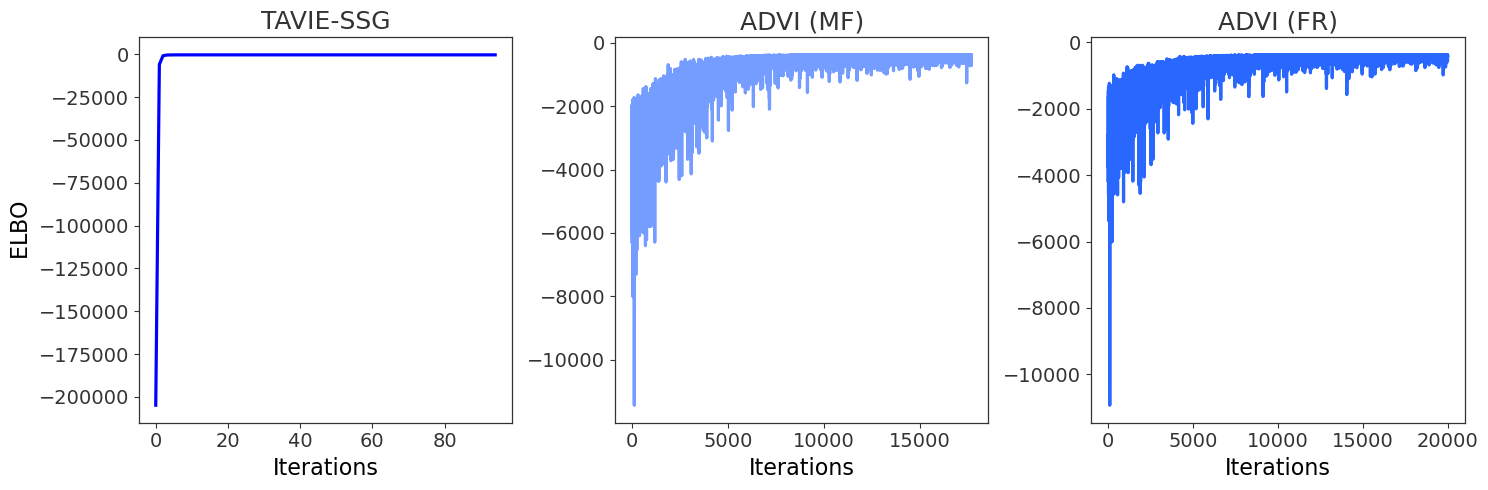

In [33]:
tavie_elbo = laplace_tavie_model.get_elbo()
advi_mf_elbo = res2['elbo_hist']
advi_fr_elbo = res3['elbo_hist']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
colors = [
    'blue',  # bright aqua
    '#759DFF',  # turquoise blue
    '#2967FF'   # strong deep blue
]
axes[0].plot(tavie_elbo, color=colors[0], linewidth=2.3)
axes[0].set_title(r'TAVIE-SSG', fontsize=18, color='#333333')
axes[0].set_xlabel('Iterations', fontsize=16)
axes[0].set_ylabel(r'$\mathsf{ELBO}$', fontsize=16)

axes[1].plot(advi_mf_elbo, color=colors[1], linewidth=2.3)
axes[1].set_title(r'ADVI (MF)', fontsize=18, color='#333333')
axes[1].set_xlabel('Iterations', fontsize=16)

axes[2].plot(advi_fr_elbo, color=colors[2], linewidth=2.3)
axes[2].set_title(r'ADVI (FR)', fontsize=18, color='#333333')
axes[2].set_xlabel('Iterations', fontsize=16)

# --- Shared styling ---
for ax in axes:
    #ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(0.9)
    ax.tick_params(axis='both', labelsize=14, colors='#333333')

plt.tight_layout()
#fig.suptitle(r'$\mathsf{ELBO}$ Convergence Trajectories', fontsize=17, color='#333333', y=1.03)

# Save high-resolution figure
fig.savefig(f'results_compete/plots/Laplace_ELBO_n_{n}_p_{p}.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## For multiple sample sizes n and fixed features p=8

In [28]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
num_reps = 100
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
mse_tau2_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
mse_tau2_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
mse_tau2_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# Initialize TAVIE once
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # 1) Simulate data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack([np.ones(n), X])
        error = np.random.laplace(loc=0.0, scale=1/np.sqrt(tau2_true), size=n)
        y = X_bbvi @ beta_true + error

        # ---- TAVIE ----
        t0 = perf_counter()
        laplace_tavie_model.fit(X, y, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # DADVI estimator
        laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)
        t0 = perf_counter()
        laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = laplace_dadvi_res['beta']
        tau2_est_DADVI = np.exp(laplace_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = laplace_nuts_res['beta']
        tau2_est_NUTS = laplace_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ---- ADVI mean-field ----
        t0 = perf_counter()
        res_diag = BBVI_Laplace_patience_best(
            X_bbvi, y,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_d = res_diag['beta_mean']
        tau2_d = res_diag['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_d - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_d - tau2_true)**2

        # ---- ADVI full-rank ----
        t0 = perf_counter()
        res_full = BBVI_Laplace_fullcov_AdamW_best(
            X_bbvi, y,
            Sigma_prior=Sigma_prior,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_fr[i, rep] = perf_counter() - t0

        beta_f = res_full['beta_mean']
        tau2_f = res_full['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_f - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_f - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Laplace_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=2000: 100%|██████████| 100/100 [1:21:09<00:00, 48.69s/it]


## For multiple number of features p and fixed sample size n=1000

In [34]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 8, 15, 20]
tau2_true  = 3.0
num_reps   = 100

# Hyperparameters for BBVI full‐covariances
a, b = 0.025, 0.025

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
mse_tau2_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
mse_tau2_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
mse_tau2_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
mse_tau2_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
mse_tau2_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # 1) Simulate data
        X      = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack([np.ones(n), X])
        error  = np.random.laplace(loc=0.0, scale=1/np.sqrt(tau2_true), size=n)
        y      = X_bbvi @ beta_true + error

        # ---- TAVIE ----
        t0 = perf_counter()
        laplace_tavie_model.fit(X, y, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # DADVI estimator
        laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)
        t0 = perf_counter()
        laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = laplace_dadvi_res['beta']
        tau2_est_DADVI = np.exp(laplace_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = laplace_nuts_res['beta']
        tau2_est_NUTS = laplace_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ---- ADVI mean-field ----
        t0 = perf_counter()
        res_diag = BBVI_Laplace_patience_best(
            X_bbvi, y,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_d = res_diag['beta_mean']
        tau2_d = res_diag['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_d - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_d - tau2_true)**2

        # ---- ADVI full-rank ----
        t0 = perf_counter()
        res_full = BBVI_Laplace_fullcov_AdamW_best(
            X_bbvi, y,
            Sigma_prior=Sigma_prior,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_fr[i, rep] = perf_counter() - t0

        beta_f = res_full['beta_mean']
        tau2_f = res_full['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_f - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_f - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Laplace_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=20: 100%|██████████| 100/100 [1:30:25<00:00, 54.26s/it]


# Negative-Binomial

In [35]:
def negbin_pymc_model(X, y, r):
    """
    Negative Binomial regression:
        y ~ NB(n=r, p = sigmoid(X @ beta))
    which is equivalent to mean mu = r * exp(-X @ beta).

    r: float or array-like of length n. If float, it's broadcast to length n.
    """
    # ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n, p = X.shape

    # counts must be non-negative integers
    if not np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.int64)

    # handle r: float -> length-n vector; array -> validate length
    if np.isscalar(r):
        r_vec = np.full(n, float(r))
    else:
        r_vec = np.asarray(r, dtype=float).reshape(-1)
        if r_vec.size != n:
            raise ValueError(f"r must be scalar or length n={n}, got {r_vec.size}")
    if np.any(r_vec <= 0):
        raise ValueError("All entries of r must be > 0")

    fxdtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # data
        X_data = pm.MutableData("X", X.astype(fxdtype))
        y_data = pm.MutableData("y", y)
        r_data = pm.MutableData("r", r_vec.astype(fxdtype))

        # prior on beta
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)

        # linear predictor & link
        eta = pt.dot(X_data, beta)                 # shape (n,)
        p_nb = pm.math.sigmoid(eta)                # p in (0,1)
        mu   = pm.Deterministic("mu", r_data * pt.exp(-eta))  # for inspection

        # NB likelihood with (n=r, p=sigmoid(Xβ))
        pm.NegativeBinomial("y_obs", n=r_data, p=p_nb, observed=y_data)

    return model


def fit_NUTS_negbin(model):
    """
    Fit the NB model (with known r) using NUTS and return posterior means for beta.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    with model:
        idata = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(idata, var_names=["beta"])[["mean"]]

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    return {"beta": np.array(beta_mean)}


In [37]:
# ==== Experiment settings ====
p = 8
num_reps = 100
r = 10
n = 1000     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)

# TAVIE model initialization
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
probs = 1 / (1 + np.exp(-linear_term))
y = np.random.negative_binomial(r, probs, size=n)

# ---- TAVIE ----
negbin_tavie_model.fit(X, y, r=r, verbose=False)

# ADVI mean-field estimator
res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
    
# ADVI full-rank estimator
res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)

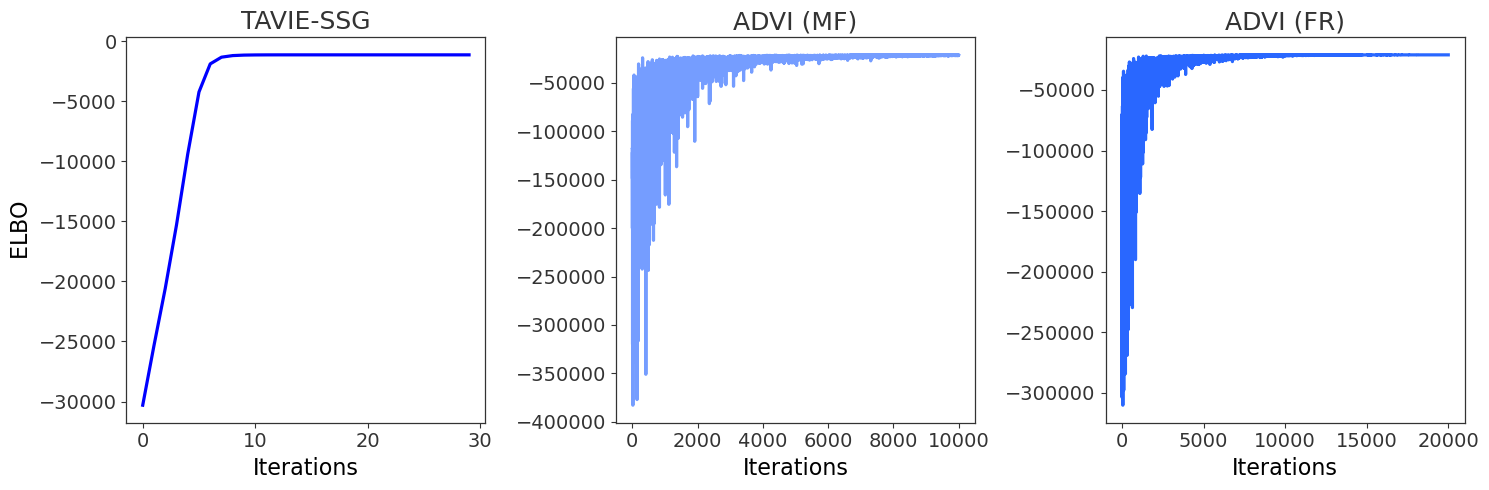

In [39]:
tavie_elbo = student_tavie_model.get_elbo()
advi_mf_elbo = res2['elbo_hist']
advi_fr_elbo = res3['elbo_hist']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
colors = [
    'blue',  # bright aqua
    '#759DFF',  # turquoise blue
    '#2967FF'   # strong deep blue
]
axes[0].plot(tavie_elbo, color=colors[0], linewidth=2.3)
axes[0].set_title(r'TAVIE-SSG', fontsize=18, color='#333333')
axes[0].set_xlabel('Iterations', fontsize=16)
axes[0].set_ylabel(r'$\mathsf{ELBO}$', fontsize=16)

axes[1].plot(advi_mf_elbo, color=colors[1], linewidth=2.3)
axes[1].set_title(r'ADVI (MF)', fontsize=18, color='#333333')
axes[1].set_xlabel('Iterations', fontsize=16)

axes[2].plot(advi_fr_elbo, color=colors[2], linewidth=2.3)
axes[2].set_title(r'ADVI (FR)', fontsize=18, color='#333333')
axes[2].set_xlabel('Iterations', fontsize=16)

# --- Shared styling ---
for ax in axes:
    #ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(0.9)
    ax.tick_params(axis='both', labelsize=14, colors='#333333')

plt.tight_layout()
#fig.suptitle(r'$\mathsf{ELBO}$ Convergence Trajectories', fontsize=17, color='#333333', y=1.03)

# Save high-resolution figure
fig.savefig(f'results_compete/plots/NegBin_ELBO_n_{n}_p_{p}.png',
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## For multiple sample sizes n and fixed features p=8

In [36]:
# ==== Experiment settings ====
p = 8
num_reps = 100
r = 10
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# TAVIE model initialization
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
        probs = 1 / (1 + np.exp(-linear_term))
        y = np.random.negative_binomial(r, probs, size=n)

        # ---- TAVIE ----
        t0 = perf_counter()
        negbin_tavie_model.fit(X, y, r=r, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)


        # DADVI estimator
        negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)
        t0 = perf_counter()
        negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = negbin_dadvi_res['beta']
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
    
        # NUTS estimator
        t0 = perf_counter()
        negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = negbin_nuts_res['beta']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    
        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/NegBin_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=2000: 100%|██████████| 100/100 [54:59<00:00, 33.00s/it]


## For multiple number of features p and fixed sample size n=1000

In [40]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 8, 15, 20]
r = 10
num_reps   = 100

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
        probs = 1 / (1 + np.exp(-linear_term))
        y = np.random.negative_binomial(r, probs, size=n)

        # ---- TAVIE ----
        t0 = perf_counter()
        negbin_tavie_model.fit(X, y, r=r, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)

        # DADVI estimator
        negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)
        t0 = perf_counter()
        negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = negbin_dadvi_res['beta']
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
    
        # NUTS estimator
        t0 = perf_counter()
        negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = negbin_nuts_res['beta']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    
        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)

        

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/NegBin_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=15:   8%|▊         | 8/100 [04:20<50:02, 32.64s/it]

p=20:  24%|██▍       | 24/100 [13:18<39:34, 31.25s/it] 

p=20:  37%|███▋      | 37/100 [20:21<33:19, 31.74s/it]

p=20:  49%|████▉     | 49/100 [26:49<26:55, 31.68s/it]

p=20:  73%|███████▎  | 73/100 [39:54<14:15, 31.67s/it]

p=20: 100%|██████████| 100/100 [54:31<00:00, 32.72s/it]
